Get data

In [1]:
'''
import io
import requests
url = "https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv"
s = requests.get(url).content
'''

'\nimport io\nimport requests\nurl = "https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv"\ns = requests.get(url).content\n'

In [0]:
from IPython.display import display

import pandas as pd
import numpy as np
from fastai.text import *

In [3]:
path = untar_data(URLs.IMDB_SAMPLE);
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/data_lm.pkl'),
 PosixPath('/root/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/root/.fastai/data/imdb_sample/data_clas_export.pkl'),
 PosixPath('/root/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/root/.fastai/data/imdb_sample/data_lm_export.pkl'),
 PosixPath('/root/.fastai/data/imdb_sample/models')]

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

Getting data ready for modeling

In [0]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [7]:
df_trn.shape, df_val.shape

((600, 3), (400, 3))

In [8]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df=df_val,path=path)

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df=df_val,path=path,
                                      vocab = data_lm.train_ds.vocab, bs=32)
data_clas.show_batch()

text,target
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj the trouble with the book , "" xxmaj memoirs of a xxmaj geisha "" is that it had xxmaj japanese surfaces but underneath the surfaces it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by xxunk animals dressed in those xxunk far from xxmaj japanese",negative
"xxbos xxmaj the year 2005 saw no xxunk than 3 filmed productions of xxup h. xxup g. xxmaj wells ' great novel , "" xxmaj war of the xxmaj worlds "" . xxmaj this is perhaps the least well - known and very probably the best of them . xxmaj no other version of xxunk has ever attempted not only to present the story very much as xxmaj wells wrote",positive
"xxbos xxmaj well , what can i say . \n \n "" xxmaj what the xxmaj bleep do we xxmaj know "" has achieved the nearly impossible - leaving behind such masterpieces of the genre as "" xxmaj the xxmaj postman "" , "" xxmaj the xxmaj dungeon xxmaj master "" , "" xxmaj xxunk "" , and so fourth , it will go down in history as the",negative
"xxbos xxmaj although recognized as the best film treatment of the difficulties of having a house in the country built ( or bought ) to your xxunk , it is not the first , nor the last . xxmaj in xxunk xxmaj jack xxmaj xxunk and xxmaj ann xxmaj xxunk were the leads in the film version of the comedy xxup george xxup washington xxup xxunk xxup here by xxmaj",positive


In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

Fine-tuning LM

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.308693,3.852562,0.288893,00:09


In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7);
learn.load_encoder('ft_enc');

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.00E-02


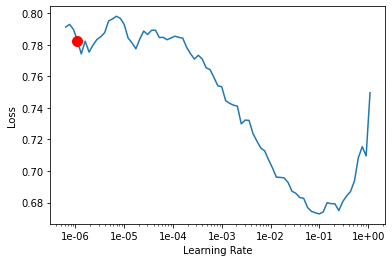

In [14]:
learn.save('init')
learn.recorder.plot(suggestion=True)


epoch,train_loss,valid_loss,accuracy,time
0,0.668282,0.652124,0.667500,00:07


Min numerical gradient: 6.38E-04
Min loss divided by 10: 6.38E-05


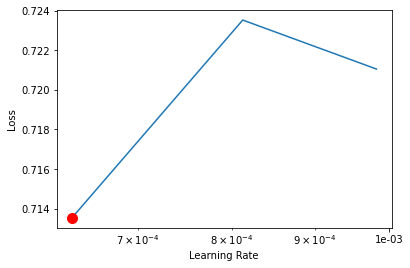

In [15]:
lr = 1.45E-03
learn.load('init');
learn.fit_one_cycle(1, lr)
learn.save('first');
learn.load('first');
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.600302,0.588418,0.717500,00:07


Min numerical gradient: 4.32E-04
Min loss divided by 10: 6.65E-05


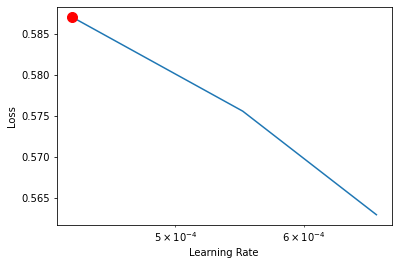

In [16]:
lr = 9.82E-04

learn.load('first');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr))
learn.save('second');
learn.load('second');
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.576387,0.551886,0.732500,00:07


Min numerical gradient: 2.37E-04
Min loss divided by 10: 2.37E-05


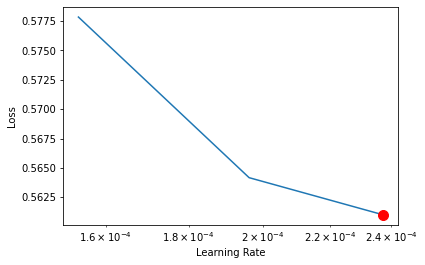

In [17]:
lr = 3.5E-04

learn.load('second');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr))
learn.save('third');
learn.load('third');
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.534184,0.526523,0.740000,00:08


Min numerical gradient: 1.35E-04
Min loss divided by 10: 8.79E-06


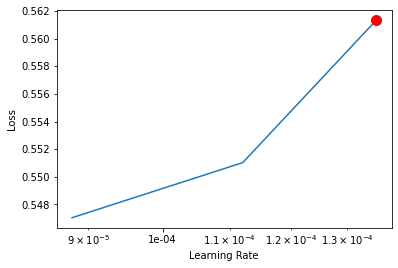

In [18]:
lr = 2E-04

learn.load('third');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr))
learn.save('fourth');
learn.load('fourth');
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.511914,0.516891,0.750000,00:07


Min numerical gradient: 9.14E-05
Min loss divided by 10: 5.94E-06


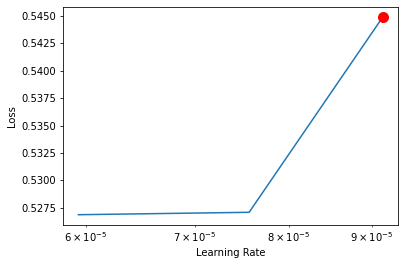

In [19]:
lr = 1.35E-04

learn.load('fourth');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr))
learn.save('fifth');
learn.load('fifth');
learn.recorder.plot(suggestion=True)

In [20]:
lr = 9.14E-05

learn.load('fifth')
learn.fit_one_cycle(10, slice(lr/(2.6**4), lr))
learn.save('f_tuned')

epoch,train_loss,valid_loss,accuracy,time
0,0.519836,0.515669,0.737500,00:07
1,0.522151,0.511393,0.737500,00:07
2,0.490593,0.503035,0.742500,00:08
3,0.485790,0.496656,0.752500,00:07
4,0.495407,0.497262,0.752500,00:08
5,0.484603,0.491323,0.757500,00:07
6,0.486257,0.493248,0.760000,00:08
7,0.477740,0.491428,0.762500,00:07
8,0.461953,0.491238,0.757500,00:07
9,0.472125,0.490517,0.755000,00:07


In [51]:
learn.load('f_tuned')

import re

positive_review = """
I don't know the stars, or modern Chinese teenage music - but I do know a thoroughly entertaining movie when I see one.<br /><br />Kung Fu Dunk is pure Hollywood in its values - it's played for laughs, for love, and is a great blend of Kung Fu and basketball.<br /><br />Everybody looks like they had a lot of fun making this - the production values are excellent - and modern China looks glossier than Los Angeles here.<br /><br />The plot of the abandoned orphan who grows up in a kung fu school only to be kicked out and then discover superstardom as a basketball play (and love and more etc;) is great - this is fresh, fun, and immensely entertaining.<br /><br />With great action and good dialogue this is one simply to enjoy - for all ages - and for our money was one of the best family movies we're seen in a long time.<br /><br />Please ignore the negative reviews and give Dunk a chance - we were really glad we did - a GOOD sports comedy movie.
"""

negative_review = """
I loved the first "Azumi" movie. I\'ve seen Ms. Ueto in a variety of her TV appearances and I\'ve seen my fair share of samurai and ninja flicks. I have to say that this movie was much weaker than I\'d expected.<br /><br />Given the movie\'s cast and set up in "Azumi", they should have been able to do a much better job with this movie, but instead it was slow, plodding in parts, and sprinkled with very poor, unconvincing, and wooden acting.<br /><br />When they bothered to reference the first movie, they did so in a manner that was pretty loose and weak. In "Azumi", the title character is the best of a group of superior killers. In "Azumi 2" she seems somehow diminished and less-impressive.<br /><br />That\'s not to say it was a total loss. There were a few decent fight scenes and some over-the-top characters. Unfortunately, the movie suffers overall from the simple fact that Shusuke Kaneko and Yoshiaki Kawajiri are not Ryuhei Kitamura and Isao Kiriyama. The latter two truly captured the "manga" feel in their screenplay whereas the former never quite "got it.
"""


def predict(sent):
  sent = re.sub('\s+', ' ', sent)
  (pred, predraw, tens) = learn.predict(sent)
  return (pred.obj, predraw, tens)

display(predict(positive_review))
display(predict(negative_review))


('positive', tensor(1), tensor([0.2681, 0.7319]))

('negative', tensor(0), tensor([0.6362, 0.3638]))

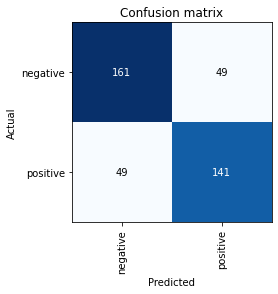

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()